In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Input, layers
import random
from keras_tuner import HyperModel, RandomSearch, Hyperband
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam, Adagrad, Adadelta, SGD 
import pandas as pd 
from keras.callbacks import ReduceLROnPlateau, Callback
import os 

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)



# loading and preprocessing code as given in the assignment

In [2]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale',
        #seed=seed
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data



# Function to randomly select 15 samples from the dataset and display the image along with its corresponding label as text on top of the image

In [3]:
def visualize_batch(df):

    #Iterating through the different batches
    image_batch, label_batch = next(df)

    #Deriving the class names
    class_names = train_data.class_indices

    #Creating 1 figure with 15 subplots
    fig, ax = plt.subplots(nrows= 5, ncols = 3, figsize = (10, 10))

    #Flatten the axis allowing for easier assignment of 'i'
    ax = ax.flatten()
    for i in range(15):

        #For every ax[i], display the image on the index
        ax[i].imshow(image_batch[i], cmap = 'gray')
        ax[i].axis('off')

        #Deriving the class number and class name
        class_number = label_batch[i].argmax()

        #Displaying the class name and its corresponding number
        for name, number in class_names.items():

            #Checking which number corresponds to the class number
            if number == class_number:
                class_name = name
                ax[i].set_title(f'Class: {class_name} ({class_number})')

    plt.tight_layout()
    plt.show()

# Bar plot to visualize the class label distribution of the dataset.

In [4]:
def plot_class_distribution(train_data, test_data):
    for data in [("Training", train_data), ("Test", test_data)]:
      class_labels = list(data[1].class_indices.keys())
    
      class_counts = [np.sum(data[1].labels == i) for i in range(len(class_labels))]
    
      plt.figure(figsize=(8, 6))
      bars = plt.bar(class_labels, class_counts)
      plt.xlabel("Class Labels")
      plt.ylabel("Number of Samples")
      plt.title(f"Class Label Distribution for {data[0]} dataset")
    
      for bar in bars:
          yval = bar.get_height()
          plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


# Split the training set into 20% validation and 80% training

In [5]:
def train_val_split(df,val_split = 0.2):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the training data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the training dataset {n_samples}')
    print()

    #Setting the size of the train and validation set according to the required split and testing if all batches are included
    val_batches = int(n_batches * val_split)
    train_batches = n_batches - val_batches

    print(f'Number of training data batches with val split of {val_split}: {train_batches}')
    print(f'Number of validation data batches: {val_batches}')
    print()
    assert train_batches + val_batches == n_batches, 'Train and val batches do not add up to total n batches'




    #Iterating through the batches and appending them into lists for train and val
    x_train, y_train = list(), list()
    x_val, y_val = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        if batch < train_batches:
            x_train.append(x)
            y_train.append(y)

        else:
            x_val.append(x)
            y_val.append(y)

    assert len(x_train) + len(x_val) == n_batches, 'Error in dividing batches into train and val sets'


    #Converting the lists into arrays suited for Tensorflow
    x_train = tf.concat(x_train, axis = 0)
    y_train = tf.concat(y_train, axis = 0)
    x_val = tf.concat(x_val, axis = 0)
    y_val = tf.concat(y_val, axis = 0)

    print(f'Shape of image training set: {x_train.shape}')
    print(f'Shape of image validation set: {x_val.shape}')
    print()
    print(f'Shape of label training set: {y_train.shape}')
    print(f'Shape of label validation set: {y_val.shape}')

    #Testing to see if all the samples are included
    assert x_train.shape[0] + x_val.shape[0] == n_samples, 'Error, not all samples included'



    return x_train, y_train, x_val, y_val

# Convert the test test to numpy array

In [6]:
def test_splits(df):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the test data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the test dataset {n_samples}')
    print()

    #Iterating through the batches and appending them into lists for train and val
    x_test, y_test = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        x_test.append(x)
        y_test.append(y)

    #Converting the lists into arrays suited for Tensorflow
    x_test = tf.concat(x_test, axis = 0)
    y_test = tf.concat(y_test, axis = 0)

    print(f'Shape of image test set: {x_test.shape}')
    print()
    print(f'Shape of label test set: {y_test.shape}')

    #Testing to see if all the samples are included
    assert  x_test.shape[0] == n_samples, 'Error, not all samples included'
    return x_test, y_test

# Functions to get plots for training and validation metrics, plot roc curve and confusion metrics

In [7]:
# plot diagnostic learning curves
def summarize_metric(history, metric):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(range(1,len(history.history[metric]) + 1),history.history[metric], color='red', label=f'Train {metric}')
    plt.plot(range(1,len(history.history[f'val_{metric}']) + 1),history.history[f'val_{metric}'], color='green', label=f'Validation {metric}')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.grid(True, which='both', linestyle='-')
    val_metric = history.history[f'val_{metric}']
    if metric == "loss":
        best_epoch = val_metric.index(min(val_metric)) + 1
    else:
        best_epoch = val_metric.index(max(val_metric)) + 1

    plt.scatter(best_epoch, val_metric[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()
    return



def plot_roc_curve(model, X, y, class_names):
    """
    Plots the ROC curve for the validation set without the macro-average.

    Parameters:
    - model: Trained model used to predict the validation set.
    - X:  feature data.
    - y: True labels for the dataset set.
    - class_names: List of class names for labeling the ROC curve plot.
    """

    # Get model predictions for the validation set
    y_pred = model.predict(X)
    y_true = np.argmax(y, axis=1)

    # Binarize the output for multi-class ROC curve
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_pred_bin = y_pred

    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

    return roc_auc



def plot_confusion_matrix(model, X, y, class_names, normalize=False):
    """
    Generates and plots the confusion matrix.

    Parameters:
    - model: Trained model used to predict the dataset.
    - X: Feature data (validation or test set).
    - y: True labels for the dataset.
    - class_names: List of class names for labeling the confusion matrix.
    - normalize: If True, normalize the confusion matrix by dividing by the sum of rows.
    """
    # Get model predictions
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Normalize confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)

    # Customize the plot
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Putting it all together 

## Set the data directory

In [8]:
# Set the paths based on your Drive directory
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


## Load train and test data. (Code as given by professor)

In [9]:


# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Visualize 15 samples from training dataset 

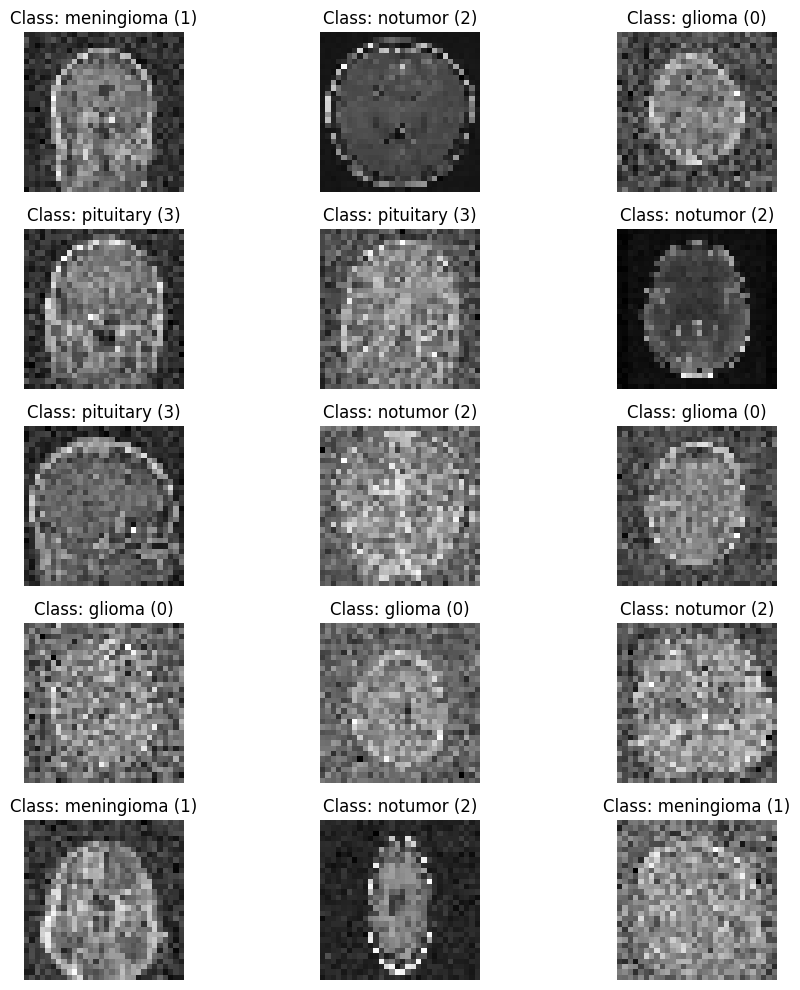

In [10]:


visualize_batch(train_data)


## Plot training and test class distribution

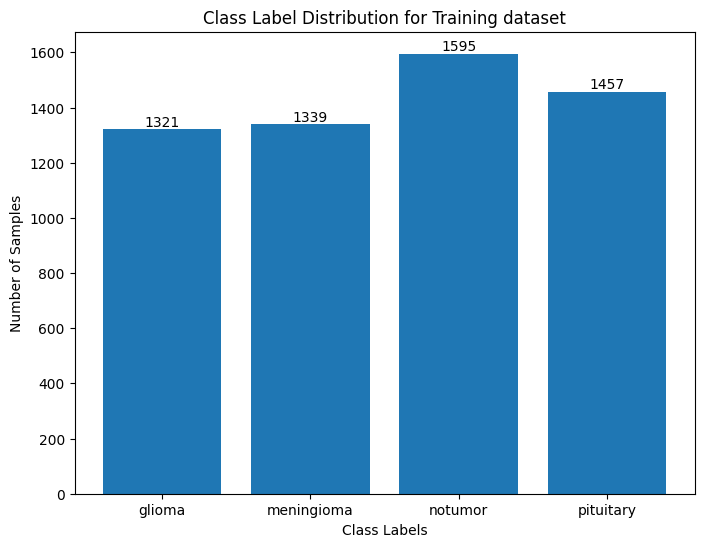

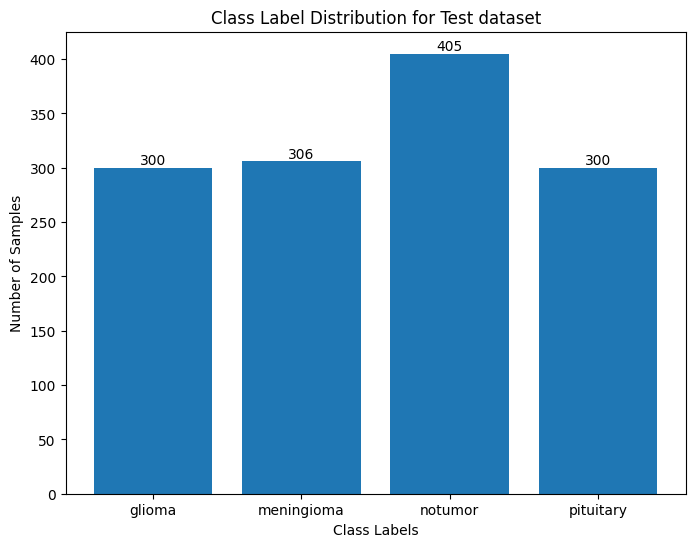

In [11]:
plot_class_distribution(train_data, test_data)

## Get train, val and test sets as numpy arrays

In [12]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


## Get class names from training and testing

In [13]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())

In [14]:
def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam",
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
    return baseline

In [15]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4378 - loss: 1.1887 - val_accuracy: 0.6721 - val_loss: 0.8587
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7181 - loss: 0.7542 - val_accuracy: 0.7292 - val_loss: 0.7105
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7694 - loss: 0.6324 - val_accuracy: 0.7409 - val_loss: 0.6542
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7905 - loss: 0.5691 - val_accuracy: 0.7527 - val_loss: 0.6271
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8032 - loss: 0.5271 - val_accuracy: 0.7591 - val_loss: 0.6109
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8193 - loss: 0.4926 - val_accuracy: 0.7690 - val_loss: 0.6061
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8308 - loss: 0.4606 - val_accuracy: 0.7672 - val_loss: 0.6051
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8449 - loss: 0.4323 - val_accuracy

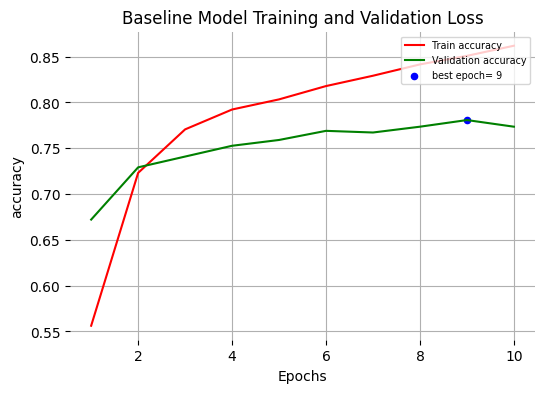

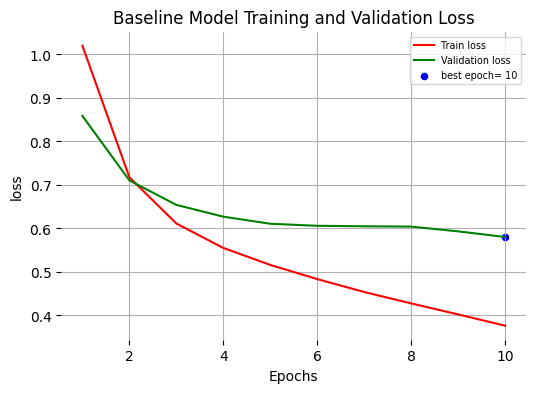

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


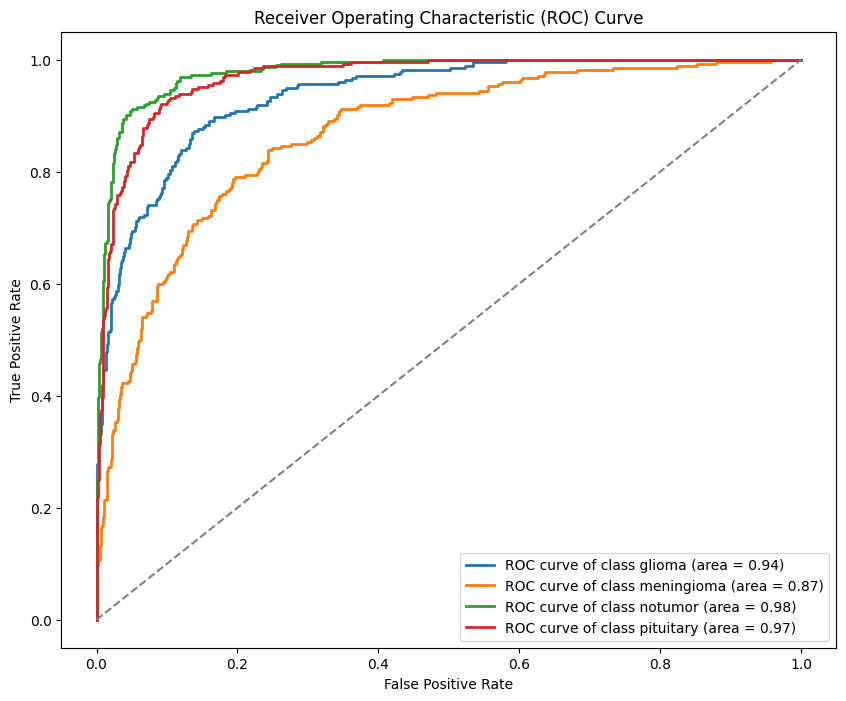

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


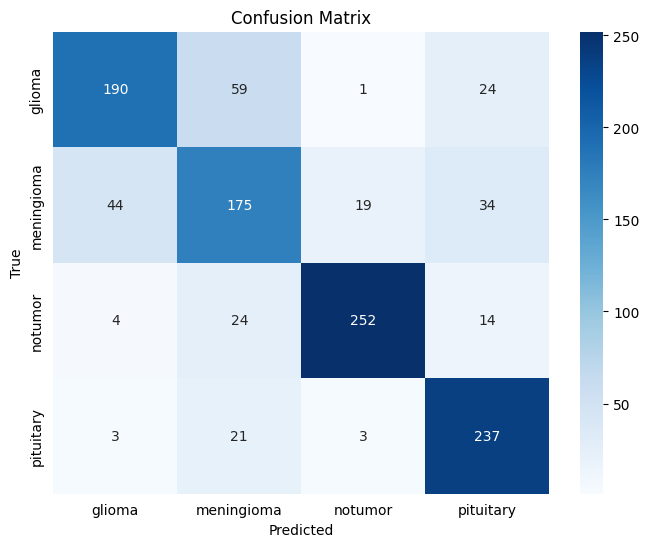

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


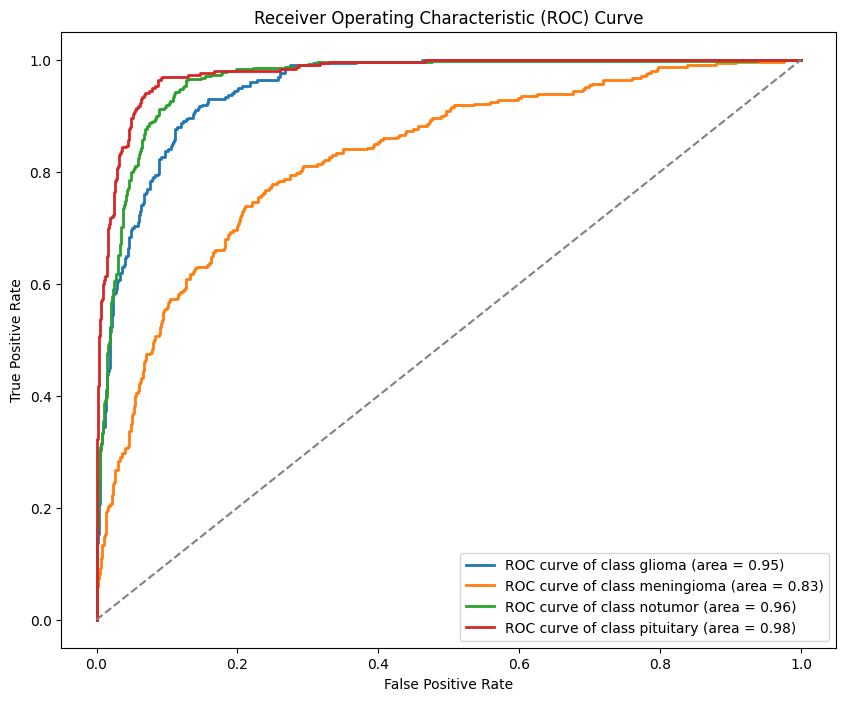

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


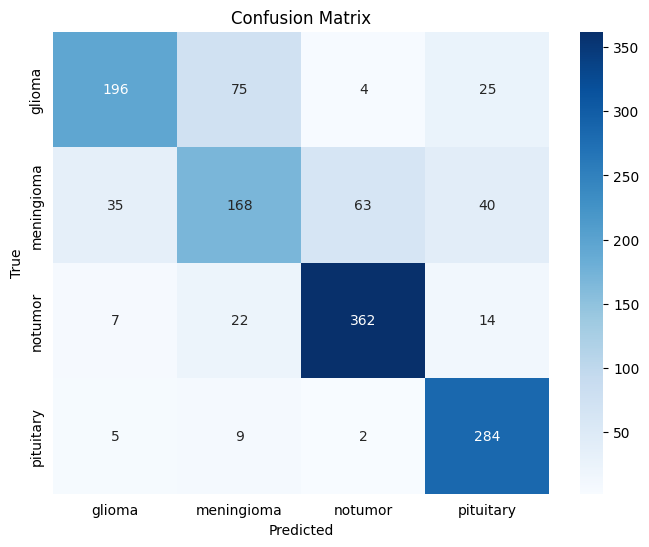

In [16]:
summarize_metric(history, "accuracy")
summarize_metric(history, "loss")

roc_auc_val = plot_roc_curve(base, X_val, y_val, class_names_train)
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False)

roc_auc_val = plot_roc_curve(base, X_test, y_test, class_names_test)
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False)


# Add basic model for hyperparameter tuning.
dense units, filters, kernels, max pooling, activation, LR are all tuneable

In [22]:
# keras tuner selects a combination of all hyperparameters at each run from the available options.
def model_hyperparameter_tuning(hp):
    # Initialize sequential model
    model = Sequential()
    # input layer
    model.add(Input(shape=(30, 30, 1)))

    # add two conv blocks as per assignment baseline model requirements
    for i in range(1, 3):
        # conv_filters_i is hyperparameter, values are checked between 16 and 128 with 16 step
        # one value will be selected here and then a new one in next run
        conv_filters_1 = hp.Int(f"conv_filters_{i}", min_value=16, max_value=128, step=16)

        # check 3 and 5 kernel values
        kernel_choice_1 = hp.Choice(f'kernel_choice_{i}', values=[3, 5])

        # check 2x2 and 3x3 max pooling
        max_pooling_options_1 = hp.Choice(f'max_pooling_choice_{i}', values=["(2,2)", "(3,3)"])

        # Choice accepts int and str and not tuple, so convert it back to tuple
        max_pooling_choice_1 = eval(max_pooling_options_1)

        # activation function choices
        activation_choice_1 = hp.Choice(f'activation_choice_{i}', values=['relu', 'tanh', 'sigmoid'])

        # add conv block to model with chosen filter, kernel and activation choice
        model.add(layers.Conv2D(filters=conv_filters_1, kernel_size=kernel_choice_1, activation=activation_choice_1))

        # add max pooling layer
        model.add(layers.MaxPooling2D(pool_size=max_pooling_choice_1))

    # Values to test for dense layer
    dense_units_choice = hp.Int('dense_units', min_value=16, max_value=128, step=16)

    # Activation values for dense layer
    activation_choice_3 = hp.Choice('activation_choice_3', values=['relu', 'tanh', 'sigmoid'])

    # Choice of optimizers
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'adadelta', 'adagrad'])

    # Choice of initial learning rate
    lr = hp.Float('lr', min_value=1e-6, max_value=1e-1, sampling='log')

    # convert to 1D layer
    model.add(layers.Flatten())

    # Add FC layer
    model.add(layers.Dense(units=dense_units_choice, activation=activation_choice_3))

    # Add output layer with softmax
    model.add(layers.Dense(4, activation="softmax"))

    # Intitialise the chosen activation function with initial learning rate
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta(learning_rate=lr)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad(learning_rate=lr)

    # Compile the model with the chosen optimizer, loss function, and evaluation metric. 
    # categorical_crossentropy is used as it is multi-class classification and metric is accuracy since we have balanced classes.
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model


In [23]:
# resource: https://www.tensorflow.org/tutorials/keras/keras_tuner

def tune_hyperparameters(model_function, project_name):
    
    """Function to perform hyperparameter tuning using the Hyperband search algorithm.
    
    Arguments:
    model_function: The function defining the model 
    project_name: A unique name for the project to save results, change this for every unique run
    
    Returns:
    tuner: keras tuner object """
    
    # Initialize hyperband tuner.
    tuner = Hyperband(
        model_hyperparameter_tuning, 
        objective='val_accuracy', 
        max_epochs=10,  
        factor=3, 
        directory='hyperparameter_tuning',  
        project_name=project_name  
    )
    
    # Early stopping callback if val loss does not change for 5 epochs
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    # Reduce learning rate if loss does not change for 3 epochs by 0.2 factor
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    
    # Start the hyperparameter search using the defined tuner
    tuner.search(
        X_train, y_train, 
        epochs=10, 
        validation_data=(X_val, y_val),  
        verbose=1,  
        callbacks=[stop_early, reduce_lr] 
    )
    return tuner 

def print_tuning_summary(tuner, project_name):
    """
    Print results of hyperparameter tuning amd save to csv
    
    Args:
    tuner: tuner object
    project_name: projec name to use for saving csv
    """
    trials = tuner.oracle.trials

    results = []
    
    for id, trial in trials.items():
        t = trial.hyperparameters.values.copy()
        
        t["val_accuracy"] = trial.metrics.get_best_value("val_accuracy")
        results.append(t)
    
    # Convert results to dataframe
    df_results = pd.DataFrame(results)
    
    df_results.to_csv(f'{project_name}.csv', index=False)

    # Plot score vs each hyperparameter.This will plot some extra hyperparameters that tuner uses internally. 
    for column in df_results.columns:
        if column != 'val_accuracy': 
            plt.figure(figsize=(5, 5))
            sns.scatterplot(data=df_results, x=column, y='val_accuracy')  
            plt.title(f'{column} vs. Val accuracy') 
            plt.xlabel(column)  
            plt.ylabel('Val Accuracy')  
            plt.show()
    
    # Print sorted trial results, first one is best
    tuner.results_summary()


Trial 30 Complete [00h 00m 12s]
val_accuracy: 0.676630437374115

Best val_accuracy So Far: 0.79076087474823
Total elapsed time: 00h 04m 46s


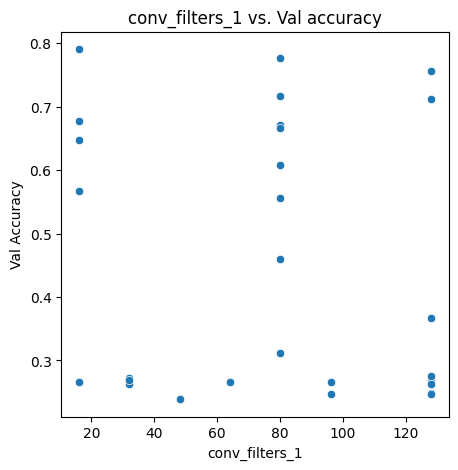

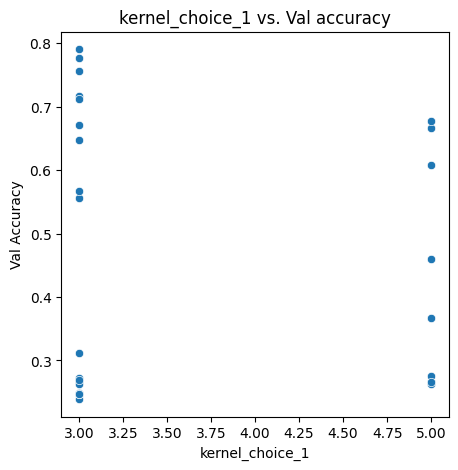

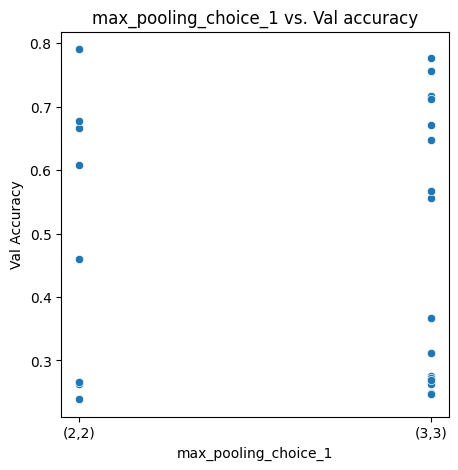

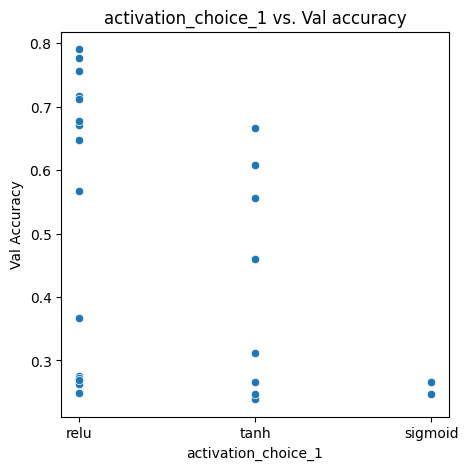

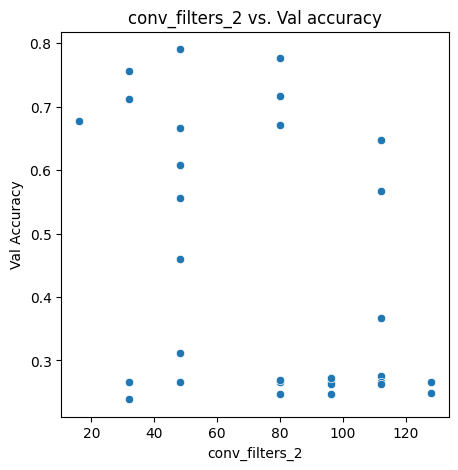

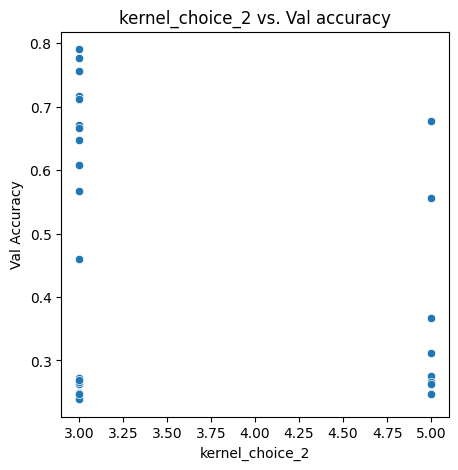

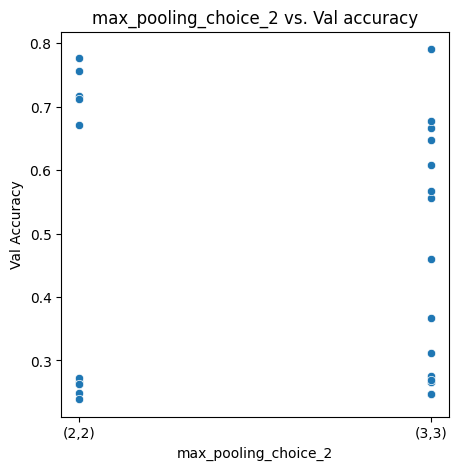

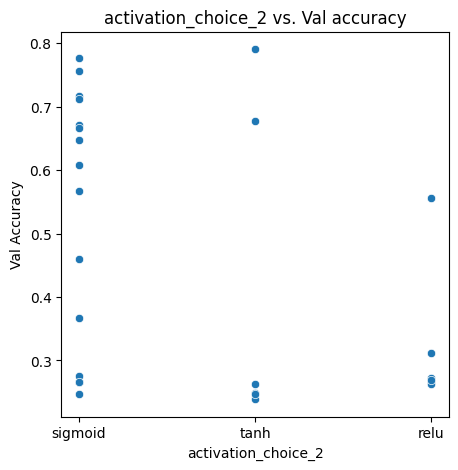

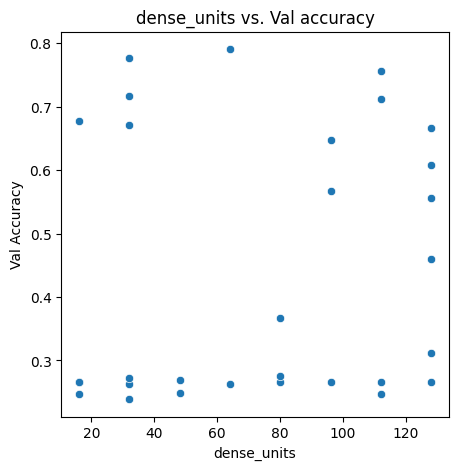

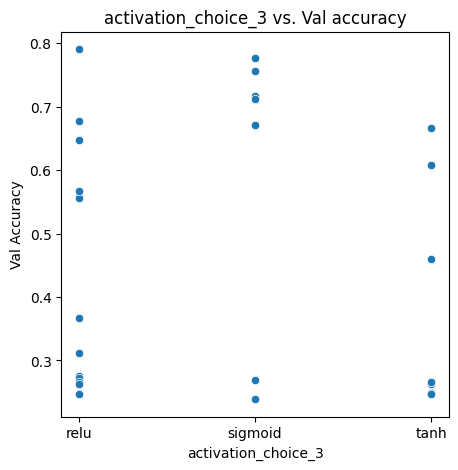

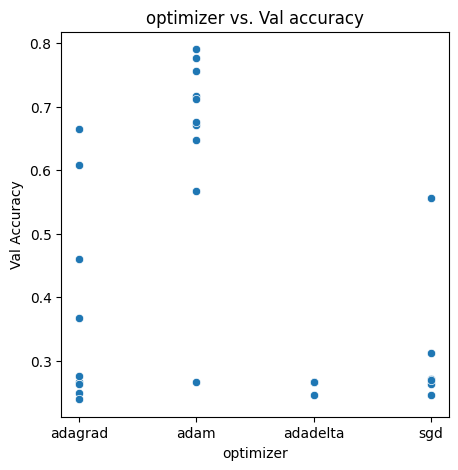

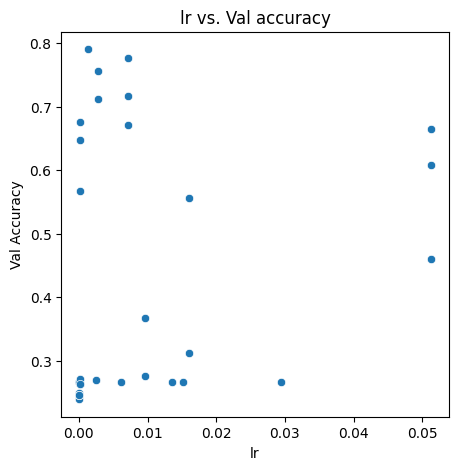

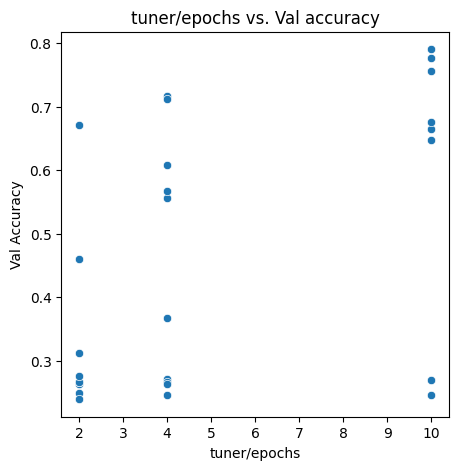

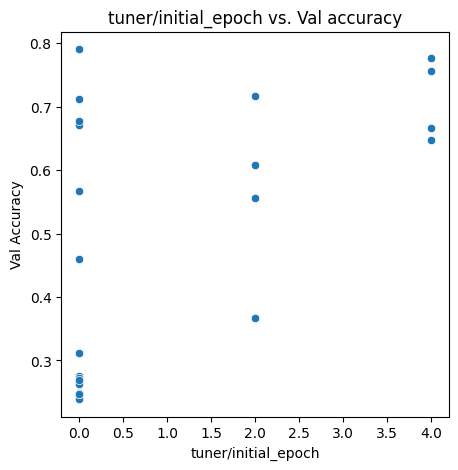

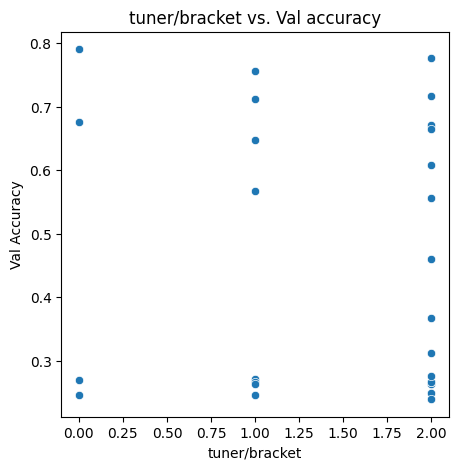

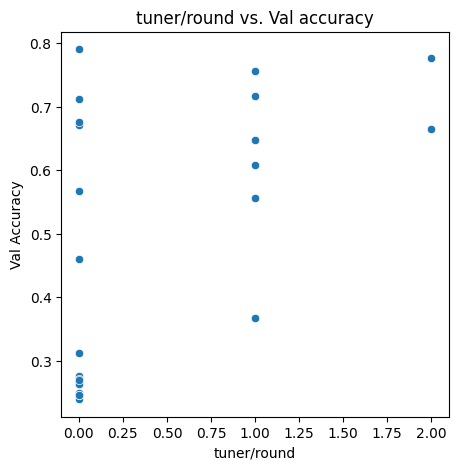

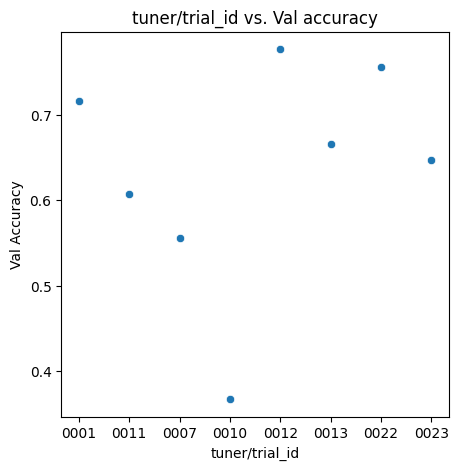

Results summary
Results in hyperparameter_tuning/baseline_hyperparameter_tuning1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0027 summary
Hyperparameters:
conv_filters_1: 16
kernel_choice_1: 3
max_pooling_choice_1: (2,2)
activation_choice_1: relu
conv_filters_2: 48
kernel_choice_2: 3
max_pooling_choice_2: (3,3)
activation_choice_2: tanh
dense_units: 64
activation_choice_3: relu
optimizer: adam
lr: 0.001344393559685498
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.79076087474823

Trial 0016 summary
Hyperparameters:
conv_filters_1: 80
kernel_choice_1: 3
max_pooling_choice_1: (3,3)
activation_choice_1: relu
conv_filters_2: 80
kernel_choice_2: 3
max_pooling_choice_2: (2,2)
activation_choice_2: sigmoid
dense_units: 32
activation_choice_3: sigmoid
optimizer: adam
lr: 0.007093525779072134
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.7771739363670349

Trial 0024 summary

In [25]:
# change this project name for every run 
project_name = "baseline_hyperparameter_tuning1"
tuner_result = tune_hyperparameters(model_hyperparameter_tuning, project_name)
print_tuning_summary(tuner_result, project_name)

# Transfer learning

## VGG16

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


# vgg16 expects (224,224,3) input. Minimum input is (32,32,3) but it will not generate good features
vgg16_resolution = 224 

# initialize VGG16 model and make it non trainable. Don't get the last FC layer by setting include_top to false
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(vgg16_resolution,vgg16_resolution,3))
base_model.trainable = False 

# initialise model 
vgg16_model = Sequential()
# add vgg16 compliant input
vgg16_model.add(Input(shape = (vgg16_resolution, vgg16_resolution, 1)))

# change our image to 224x223
vgg16_model.add(layers.Lambda(lambda x: tf.image.resize(x, (vgg16_resolution, vgg16_resolution)))) 

# change image to rgb
vgg16_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))

# add vgg16 model 
vgg16_model.add(base_model)

# add as many FC layers as needed with dropout to prevent overfitting 
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(128, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
vgg16_model.add(layers.Dense(64, activation='relu')) # only one 64 unit layer results were: accuracy: 0.7567 - loss: 0.5959 - val_accuracy: 0.6993 - val_loss: 0.7358
vgg16_model.add(layers.Dense(4, activation='softmax'))


# compile model 
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# add early stopping if accuracy does not change for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

# fit the model 
vgg16_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


Epoch 1/20
 65/144 ━━━━━━━━━━━━━━━━━━━━ 8:42 7s/step - accuracy: 0.3111 - loss: 1.6361

KeyboardInterrupt: 

## Resnet50

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with resnet50

resnet_resolution = 224 
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(resnet_resolution,resnet_resolution,3))
base_model.trainable = False ## 

resnet_model = Sequential()
resnet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
resnet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (resnet_resolution, resnet_resolution)))) 
resnet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
resnet_model.add(base_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.Dense(4, activation='softmax'))


resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

resnet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


Epoch 1/20
 16/144 ━━━━━━━━━━━━━━━━━━━━ 3:56 2s/step - accuracy: 0.2388 - loss: 5.8486

KeyboardInterrupt: 

## Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with densenet


densenet_resolution = 224
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(densenet_resolution,densenet_resolution,3))
base_model.trainable = False ## 

densenet_model = Sequential()
densenet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
densenet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (densenet_resolution, densenet_resolution)))) 
densenet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
densenet_model.add(base_model)
densenet_model.add(layers.Flatten())
densenet_model.add(layers.Dense(128, activation='relu'))
densenet_model.add(layers.Dense(4, activation='softmax'))


densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

densenet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])
